<a href="https://colab.research.google.com/github/becks-ddf/plates_repo/blob/master/dishes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle/

In [ ]:
!cp /content/drive/My\ Drive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c platesv2

 70% 33.0M/47.1M [00:00<00:00, 25.8MB/s]
100% 47.1M/47.1M [00:00<00:00, 64.5MB/s]
  0% 0.00/8.00k [00:00<?, ?B/s]
100% 8.00k/8.00k [00:00<00:00, 8.66MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/plates_data/plates.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/My Drive/plates_data/")

In [ ]:
!mkdir /content/drive/My\ Drive/plates_data

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/content/drive/My Drive/plates_data/plates"))

# Any results you write to the current directory are saved as output.

['.DS_Store', 'test', 'train', 'val']


In [3]:
working_dir = "/content/drive/My Drive/plates_data/plates"
data_root= "/content/drive/My Drive/plates_data/working"


In [4]:
print(os.listdir(data_root))

['train', 'val']


In [5]:
import shutil 
from tqdm import tqdm

train_dir = os.path.join(working_dir,'train')
val_dir = os.path.join(working_dir,'val')

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 5 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            #print(i)
            #print(file_name)
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 16/16 [00:19<00:00,  1.19s/it]


In [6]:
from PIL import Image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

img_path=os.path.join(working_dir, "train/cleaned/0003.jpg")
image = Image.open(img_path)
image.show()
# print(image)
image = ToTensor()(image).unsqueeze(0) # unsqueeze to add artificial first dimension
# image = Variable(image)
print(image.size())

torch.Size([1, 3, 256, 341])


In [7]:
import torch
import PIL
import matplotlib.pyplot as plt
import torchvision
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

def show_dataset(dataset, length=6, n=6):
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(length)))
  plt.imshow(img)
  plt.axis('off')

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1231: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


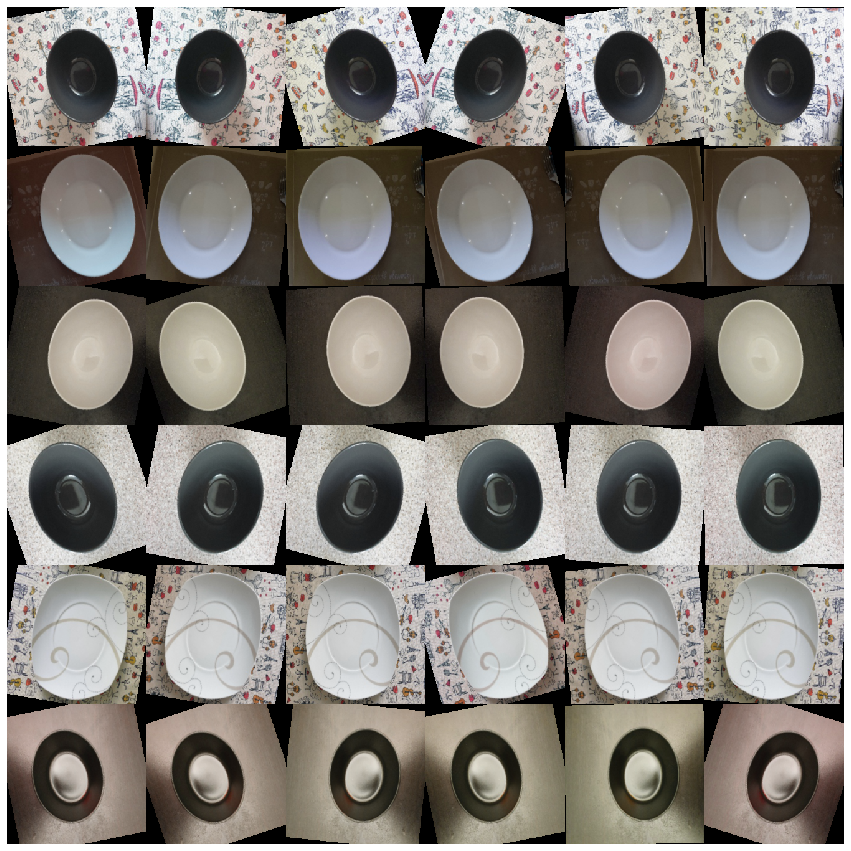

In [8]:
dataset1 = torchvision.datasets.ImageFolder(train_dir,transform=transforms)
show_dataset(dataset1)

In [9]:
from imgaug import augmenters as iaa
import imgaug as ia

class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Scale((224, 224)),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
#         iaa.Sometimes(0.25,
#                       iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
#                                  iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

transforms = ImgAugTransform()

dataset = torchvision.datasets.ImageFolder(val_dir, transform=transforms)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  import sys


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


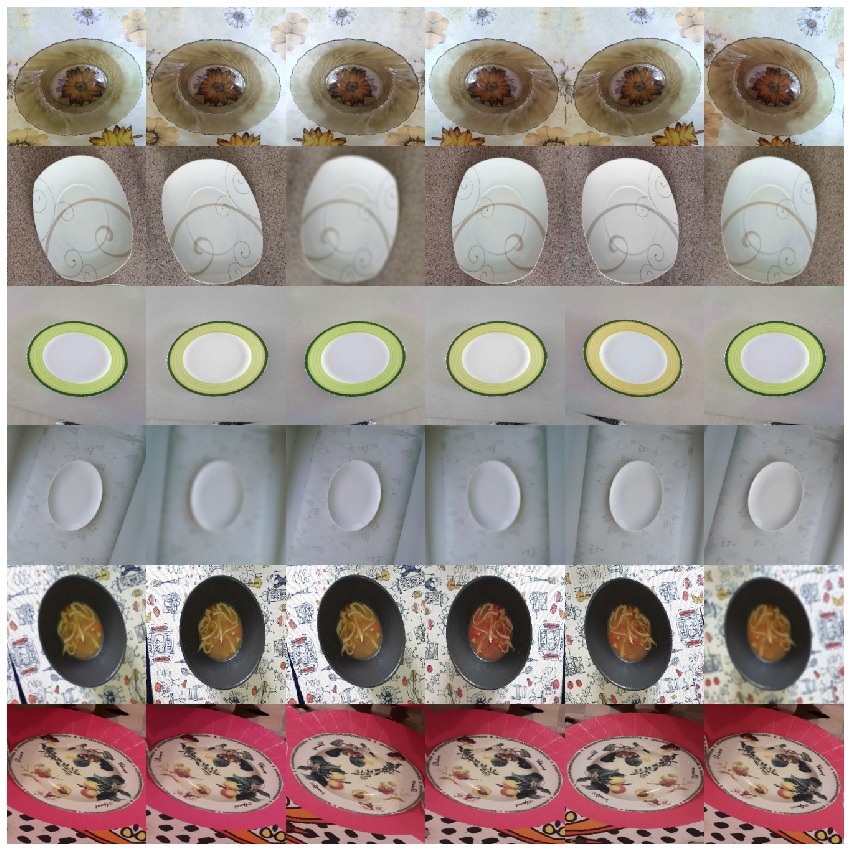

In [10]:
show_dataset(dataset)

In [11]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
#ImgAugTransform(),lambda x: PIL.Image.fromarray(x),
from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [93]:
print(len(train_dataloader), len(train_dataset))

4 32


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


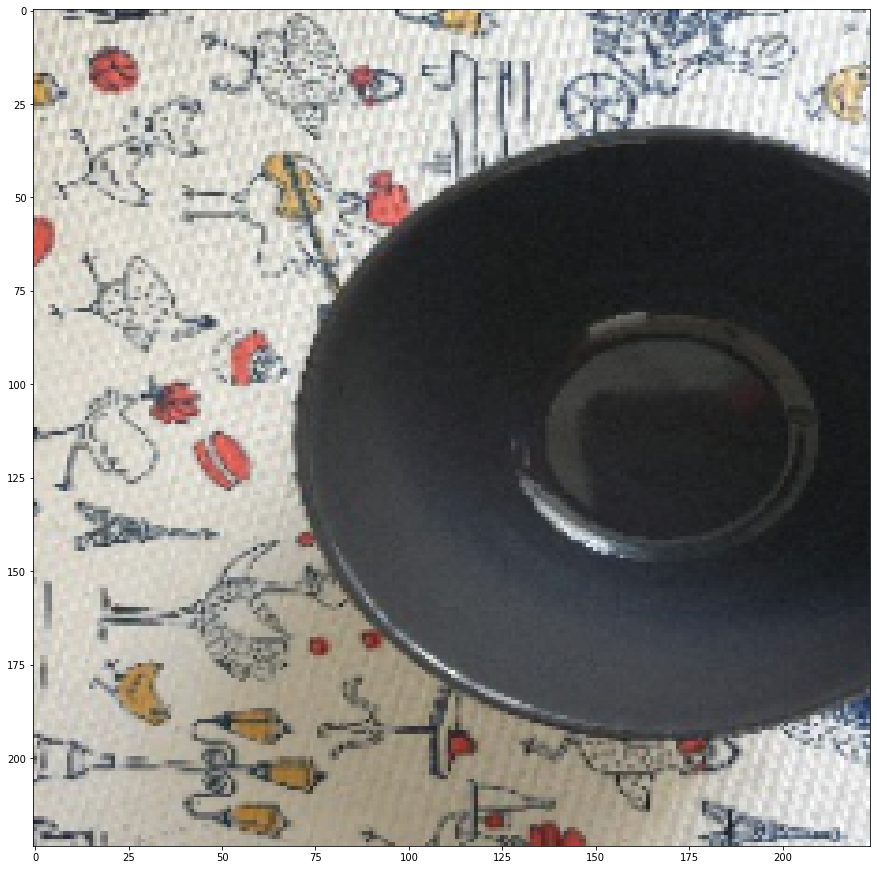

In [12]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


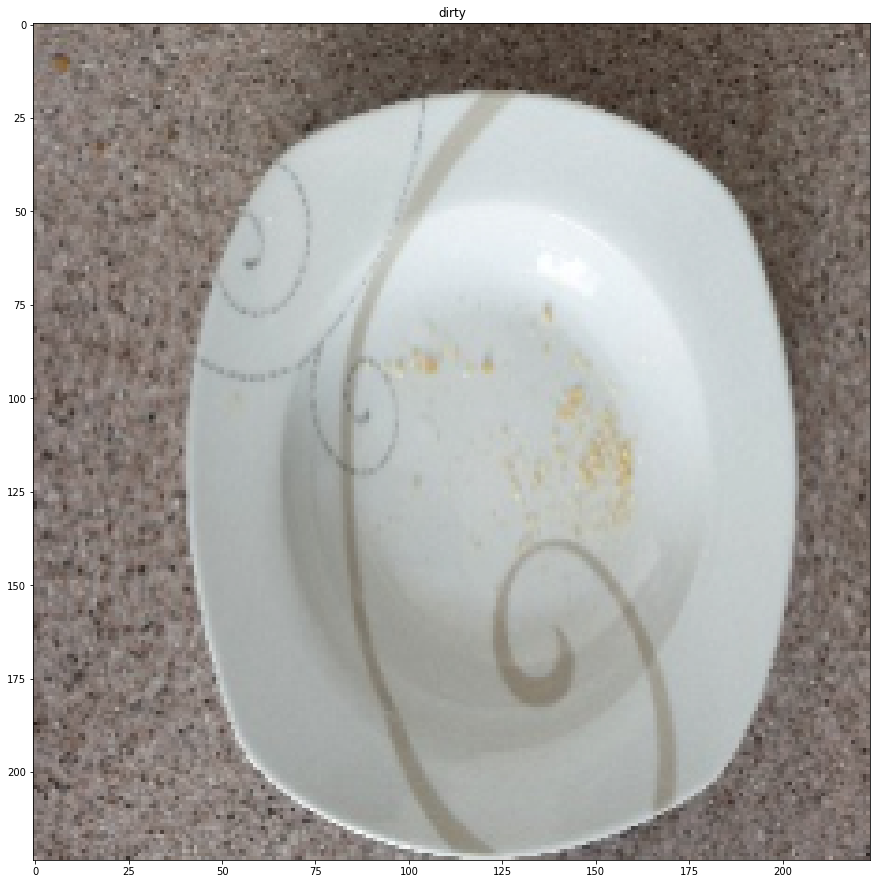

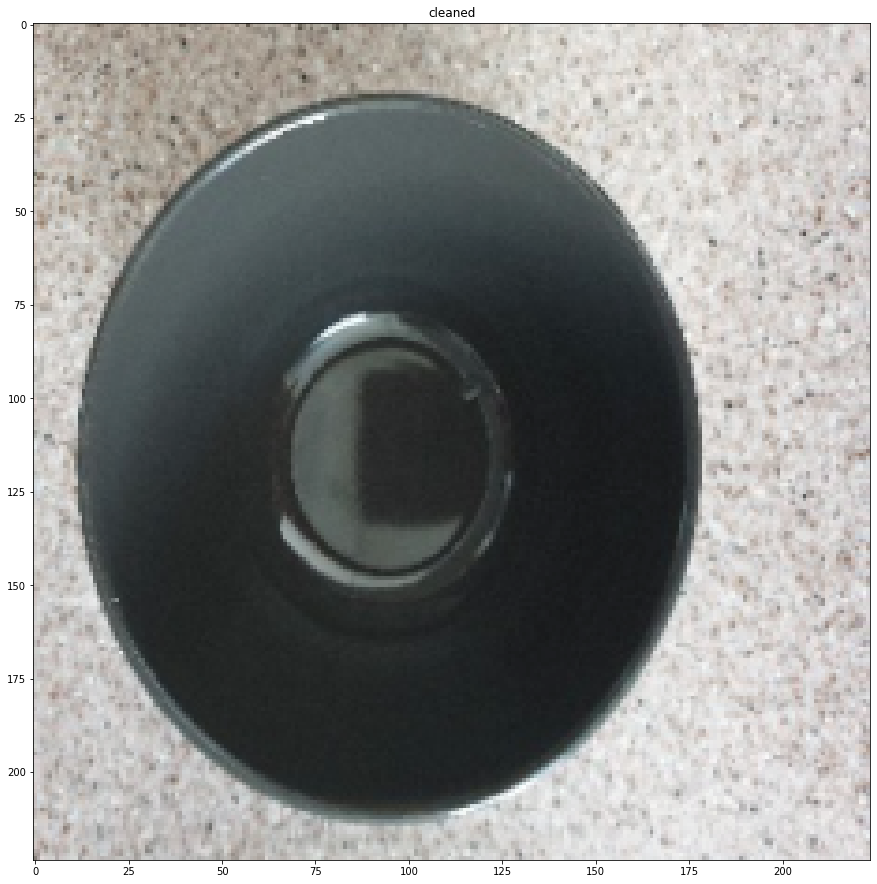

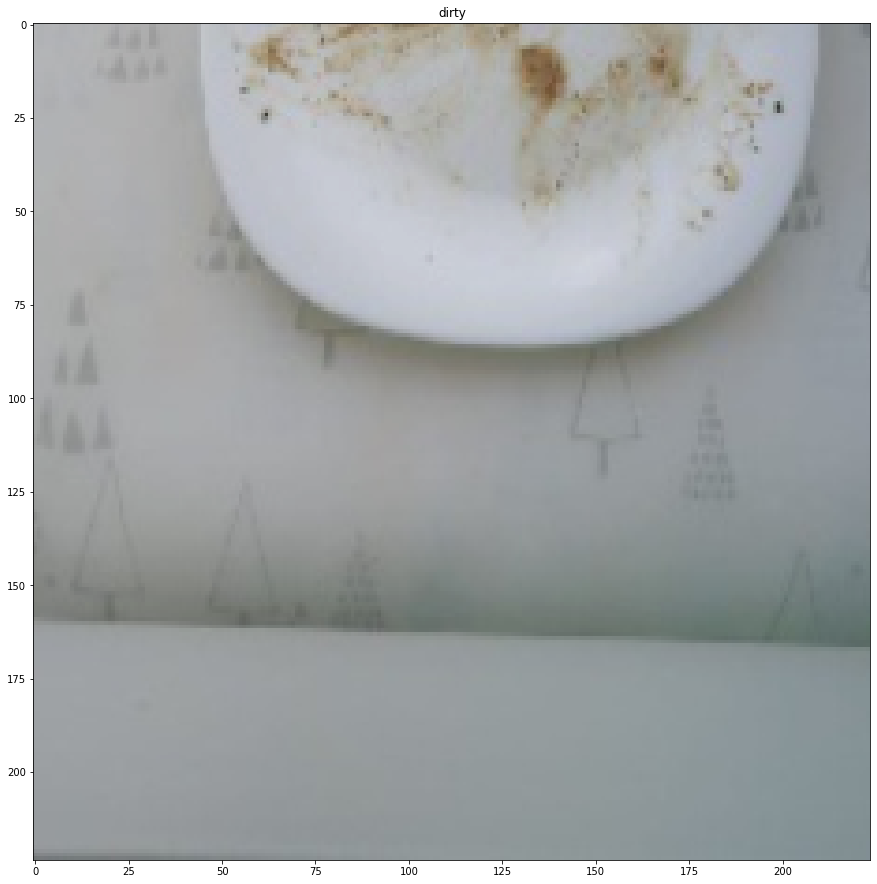

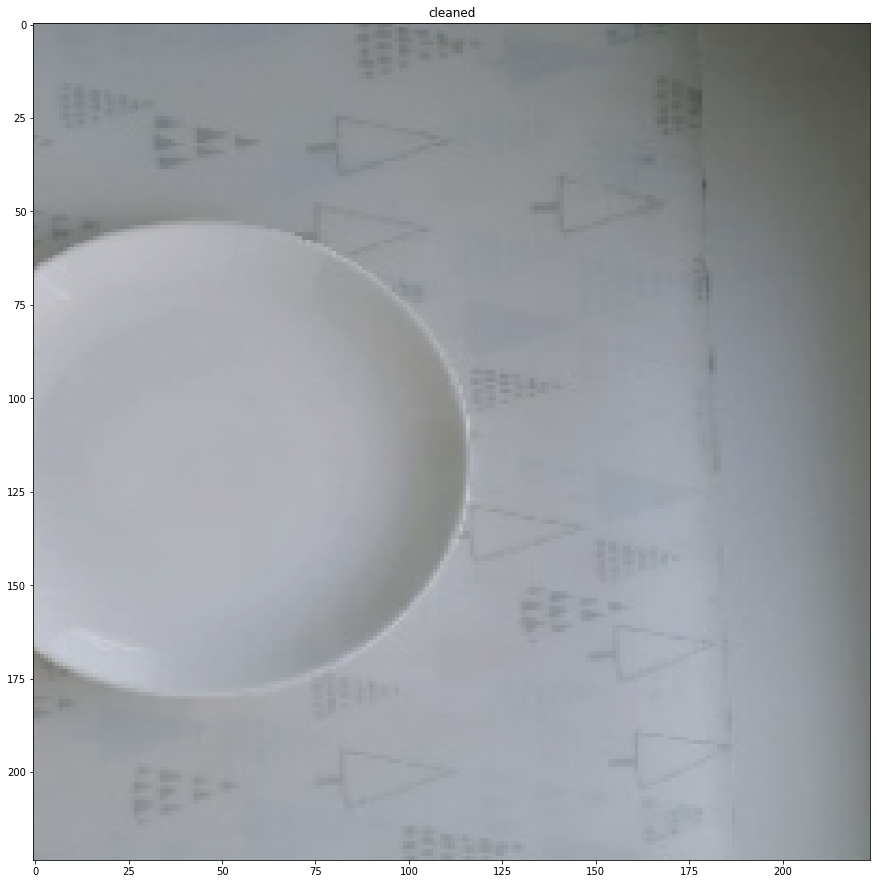

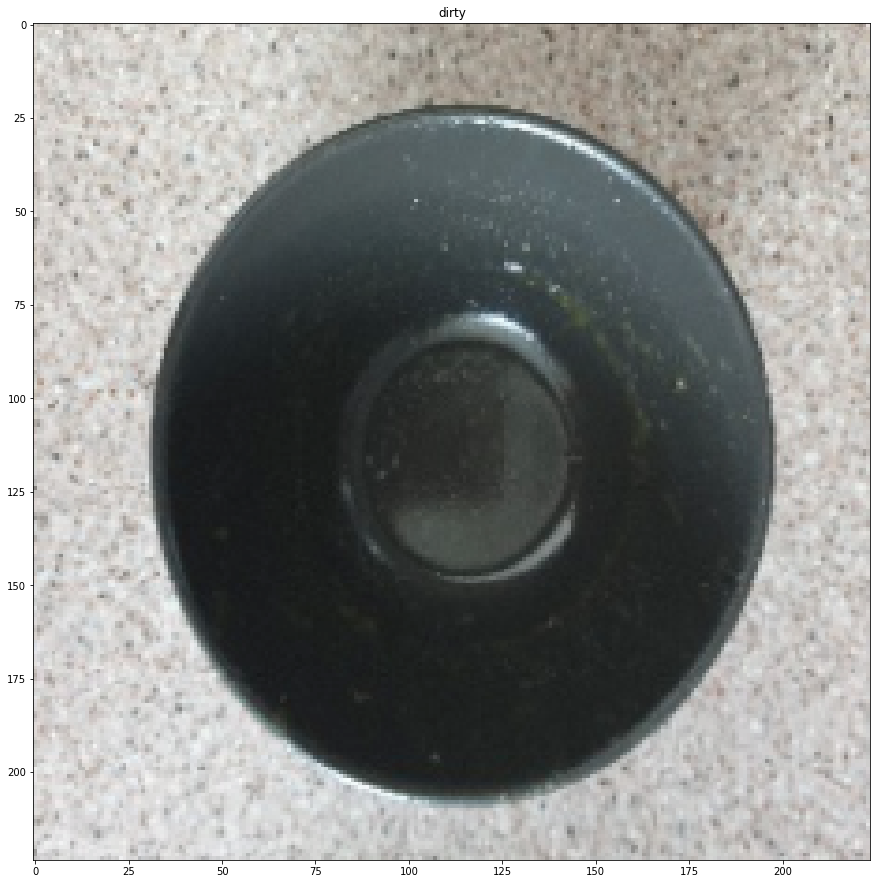

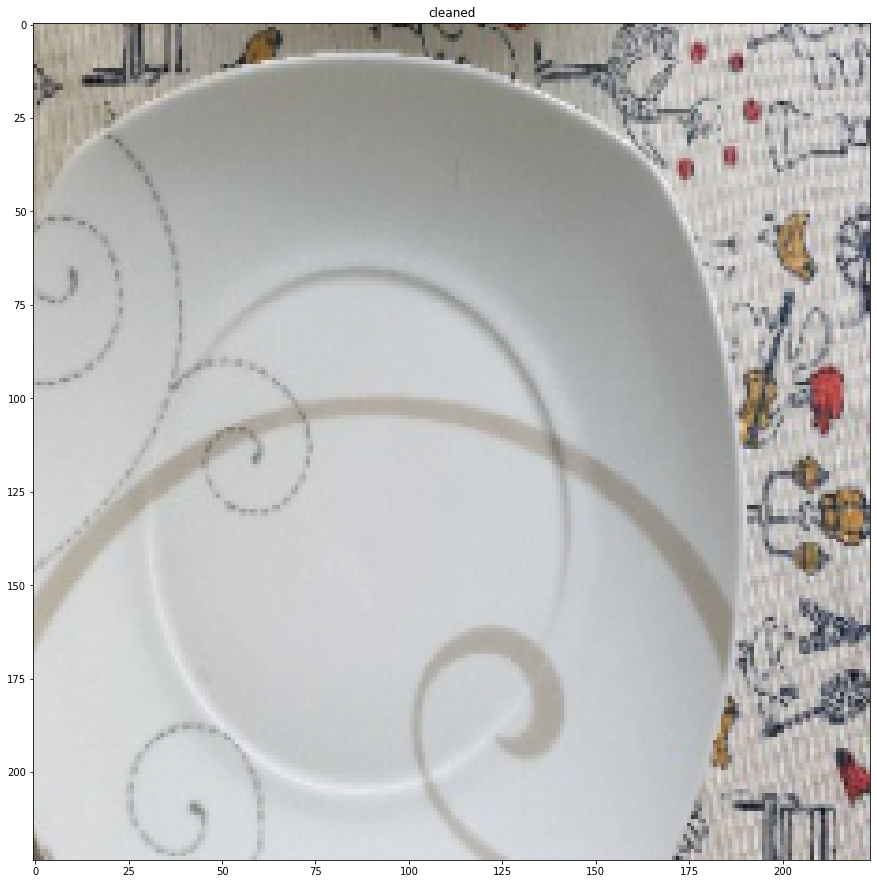

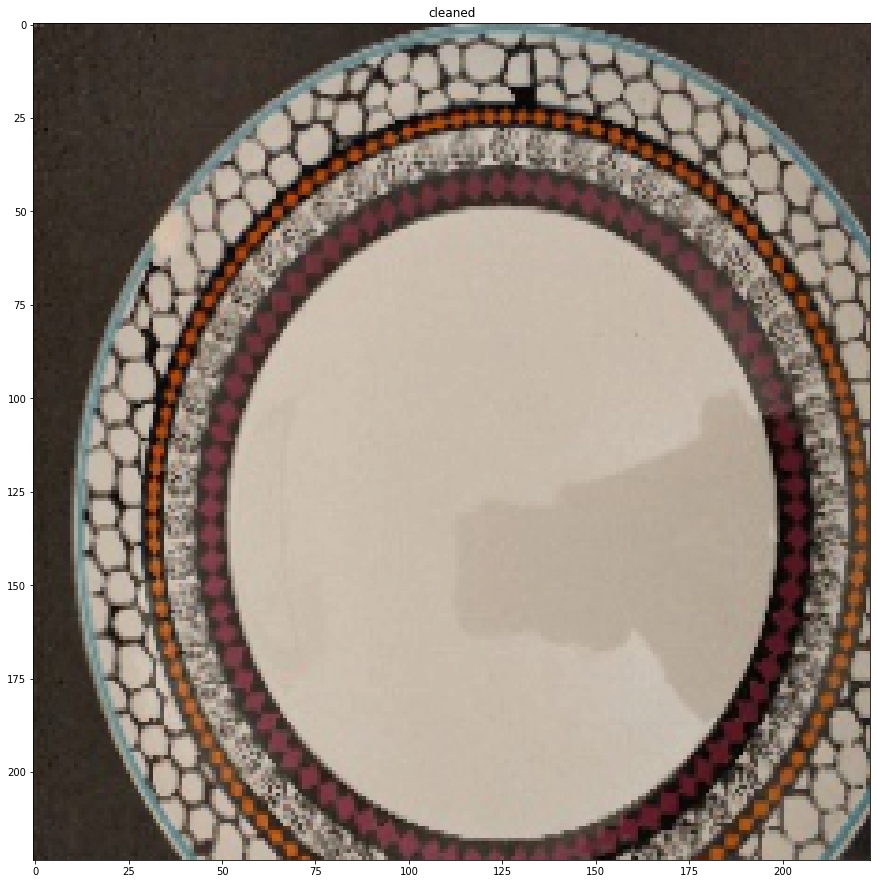

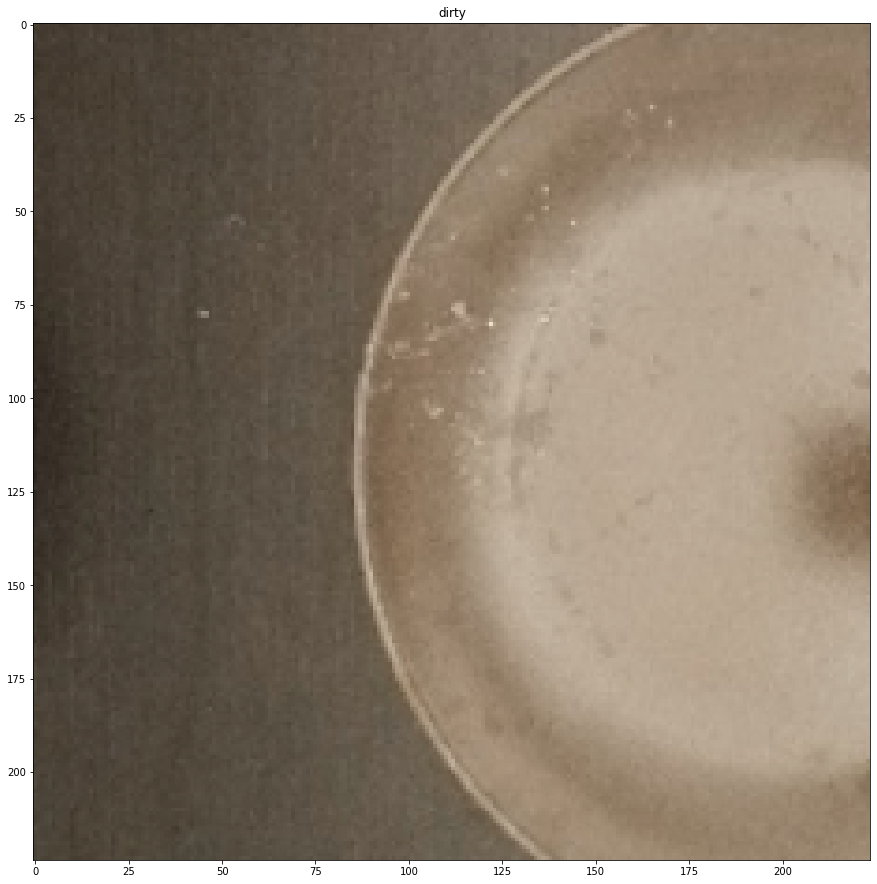

In [13]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [14]:

train_acc = []
train_loss = []
val_acc = []
val_loss = []
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
#                 scheduler.step()
                model.train()  # Set model to training mode
                acc_history=train_acc
                loss_history=train_loss
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode
                acc_history=val_acc
                loss_history=val_loss

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            loss_history.append(epoch_loss) 
            acc_history.append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            if phase == 'val': scheduler.step(epoch_loss)
    return model

In [15]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
# optimizer=torch.optim.RMSprop(model.parameters(), lr=1.0e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.7)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [48]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.6501 Acc: 0.6000



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

val Loss: 0.5654 Acc: 0.7500
Epoch 1/99:



100%|██████████| 5/5 [00:04<00:00,  1.25it/s]

train Loss: 0.6385 Acc: 0.6250



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

val Loss: 0.5783 Acc: 0.6250
Epoch 2/99:



100%|██████████| 5/5 [00:03<00:00,  1.26it/s]

train Loss: 0.5486 Acc: 0.7500



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

val Loss: 0.5098 Acc: 0.6250
Epoch 3/99:



100%|██████████| 5/5 [00:03<00:00,  1.26it/s]

train Loss: 0.5675 Acc: 0.7500



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

val Loss: 0.4956 Acc: 0.6250
Epoch 4/99:



100%|██████████| 5/5 [00:03<00:00,  1.25it/s]

train Loss: 0.5576 Acc: 0.6500



100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

val Loss: 0.4789 Acc: 0.7500
Epoch 5/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.5283 Acc: 0.7250



100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

val Loss: 0.4631 Acc: 0.7500
Epoch 6/99:



100%|██████████| 5/5 [00:04<00:00,  1.25it/s]

train Loss: 0.4743 Acc: 0.7750



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

val Loss: 0.4396 Acc: 0.7500
Epoch 7/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.4574 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

val Loss: 0.4024 Acc: 0.8750
Epoch 8/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.4215 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

val Loss: 0.3987 Acc: 0.6250
Epoch 9/99:



100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

train Loss: 0.4169 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

val Loss: 0.3698 Acc: 0.8750
Epoch 10/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.4513 Acc: 0.7750



100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

val Loss: 0.3806 Acc: 0.7500
Epoch 11/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.4789 Acc: 0.7500



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

val Loss: 0.3401 Acc: 0.8750
Epoch 12/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.3927 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

val Loss: 0.3249 Acc: 0.8750
Epoch 13/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.3763 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

val Loss: 0.3213 Acc: 0.8750
Epoch 14/99:



100%|██████████| 5/5 [00:04<00:00,  1.25it/s]

train Loss: 0.3665 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

val Loss: 0.3149 Acc: 0.8750
Epoch 15/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.4635 Acc: 0.7750



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

val Loss: 0.3284 Acc: 0.8750
Epoch 16/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.3987 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

val Loss: 0.2965 Acc: 0.8750
Epoch 17/99:



100%|██████████| 5/5 [00:04<00:00,  1.25it/s]

train Loss: 0.2721 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

val Loss: 0.2731 Acc: 0.8750
Epoch 18/99:



100%|██████████| 5/5 [00:04<00:00,  1.25it/s]

train Loss: 0.4491 Acc: 0.8000



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

val Loss: 0.2615 Acc: 0.8750
Epoch 19/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.2807 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

val Loss: 0.2589 Acc: 1.0000
Epoch 20/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.3258 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

val Loss: 0.2567 Acc: 1.0000
Epoch 21/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.4038 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

val Loss: 0.2581 Acc: 0.8750
Epoch 22/99:



100%|██████████| 5/5 [00:04<00:00,  1.25it/s]

train Loss: 0.2391 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

val Loss: 0.2375 Acc: 0.8750
Epoch 23/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.5597 Acc: 0.6750



100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

val Loss: 0.2229 Acc: 1.0000
Epoch 24/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.5320 Acc: 0.7500



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

val Loss: 0.2491 Acc: 0.8750
Epoch 25/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.3765 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

val Loss: 0.2120 Acc: 1.0000
Epoch 26/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.3516 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

val Loss: 0.2178 Acc: 1.0000
Epoch 27/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.2405 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

val Loss: 0.2106 Acc: 1.0000
Epoch 28/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.2961 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

val Loss: 0.2012 Acc: 1.0000
Epoch 29/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.4106 Acc: 0.8000



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

val Loss: 0.2059 Acc: 0.8750
Epoch 30/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.3599 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

val Loss: 0.2096 Acc: 1.0000
Epoch 31/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.2731 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

val Loss: 0.2157 Acc: 0.8750
Epoch 32/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.2278 Acc: 0.9750



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

val Loss: 0.2078 Acc: 1.0000
Epoch 33/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.2612 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

val Loss: 0.1965 Acc: 1.0000
Epoch 34/99:



100%|██████████| 5/5 [00:04<00:00,  1.25it/s]

train Loss: 0.2641 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

val Loss: 0.1983 Acc: 1.0000
Epoch 35/99:



100%|██████████| 5/5 [00:04<00:00,  1.25it/s]

train Loss: 0.2919 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

val Loss: 0.1923 Acc: 1.0000
Epoch 36/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.3182 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

val Loss: 0.1851 Acc: 1.0000
Epoch 37/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.2667 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

val Loss: 0.1938 Acc: 0.8750
Epoch 38/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.2400 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

val Loss: 0.1828 Acc: 1.0000
Epoch 39/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.3410 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

val Loss: 0.1729 Acc: 1.0000
Epoch 40/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.4212 Acc: 0.7750



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

val Loss: 0.1945 Acc: 1.0000
Epoch 41/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.3314 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

val Loss: 0.1740 Acc: 1.0000
Epoch 42/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.2119 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

val Loss: 0.1711 Acc: 1.0000
Epoch 43/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.2314 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

val Loss: 0.1752 Acc: 1.0000
Epoch 44/99:



100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

train Loss: 0.3143 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

val Loss: 0.1694 Acc: 1.0000
Epoch 45/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.2453 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

val Loss: 0.1690 Acc: 1.0000
Epoch 46/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.1744 Acc: 1.0000



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

val Loss: 0.1657 Acc: 1.0000
Epoch 47/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.3361 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

val Loss: 0.1753 Acc: 0.8750
Epoch 48/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.3272 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

val Loss: 0.1501 Acc: 1.0000
Epoch 49/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.1910 Acc: 1.0000



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

val Loss: 0.1436 Acc: 1.0000
Epoch 50/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.2884 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

val Loss: 0.1427 Acc: 1.0000
Epoch 51/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.2374 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

val Loss: 0.1659 Acc: 1.0000
Epoch 52/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.1507 Acc: 0.9750



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

val Loss: 0.1538 Acc: 1.0000
Epoch 53/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.2306 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

val Loss: 0.1396 Acc: 1.0000
Epoch 54/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.2915 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

val Loss: 0.1402 Acc: 1.0000
Epoch 55/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.5091 Acc: 0.8000



100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

val Loss: 0.1419 Acc: 1.0000
Epoch 56/99:



100%|██████████| 5/5 [00:04<00:00,  1.19it/s]

train Loss: 0.2287 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

val Loss: 0.2114 Acc: 0.8750
Epoch 57/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.2334 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

val Loss: 0.1431 Acc: 1.0000
Epoch 58/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.2371 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

val Loss: 0.1353 Acc: 1.0000
Epoch 59/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.1969 Acc: 0.9750



100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

val Loss: 0.1444 Acc: 1.0000
Epoch 60/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.2629 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

val Loss: 0.1390 Acc: 1.0000
Epoch 61/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.3190 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

val Loss: 0.1440 Acc: 1.0000
Epoch 62/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.2949 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

val Loss: 0.1458 Acc: 1.0000
Epoch 63/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.3002 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

val Loss: 0.1352 Acc: 1.0000
Epoch 64/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.1646 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

val Loss: 0.1427 Acc: 1.0000
Epoch 65/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.3326 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

val Loss: 0.1483 Acc: 1.0000
Epoch 66/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.1909 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

val Loss: 0.1530 Acc: 1.0000
Epoch 67/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.2911 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

val Loss: 0.1413 Acc: 1.0000
Epoch 68/99:



100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

train Loss: 0.3025 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

val Loss: 0.1542 Acc: 1.0000
Epoch 69/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.2214 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

val Loss: 0.1483 Acc: 1.0000
Epoch 70/99:



100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

train Loss: 0.2245 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

val Loss: 0.1321 Acc: 1.0000
Epoch 71/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.2099 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

val Loss: 0.1297 Acc: 1.0000
Epoch 72/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.3693 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

val Loss: 0.1264 Acc: 1.0000
Epoch 73/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.3449 Acc: 0.8000



100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

val Loss: 0.1368 Acc: 1.0000
Epoch 74/99:



100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

train Loss: 0.1980 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

val Loss: 0.1585 Acc: 1.0000
Epoch 75/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.2708 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

val Loss: 0.1315 Acc: 1.0000
Epoch 76/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.2677 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

val Loss: 0.1225 Acc: 1.0000
Epoch 77/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.2495 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

val Loss: 0.1620 Acc: 0.8750
Epoch 78/99:



100%|██████████| 5/5 [00:04<00:00,  1.20it/s]

train Loss: 0.1911 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

val Loss: 0.1246 Acc: 1.0000
Epoch 79/99:



100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

train Loss: 0.2766 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

val Loss: 0.1167 Acc: 1.0000
Epoch 80/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.2576 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

val Loss: 0.1113 Acc: 1.0000
Epoch 81/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.1786 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

val Loss: 0.1070 Acc: 1.0000
Epoch 82/99:



100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

train Loss: 0.1740 Acc: 1.0000



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

val Loss: 0.1059 Acc: 1.0000
Epoch 83/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.1831 Acc: 0.9750



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

val Loss: 0.1107 Acc: 1.0000
Epoch 84/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.1879 Acc: 1.0000



100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

val Loss: 0.1134 Acc: 1.0000
Epoch 85/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.1091 Acc: 1.0000



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

val Loss: 0.0953 Acc: 1.0000
Epoch 86/99:



100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

train Loss: 0.2391 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

val Loss: 0.1059 Acc: 1.0000
Epoch 87/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.1874 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

val Loss: 0.1040 Acc: 1.0000
Epoch 88/99:



100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

train Loss: 0.1980 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

val Loss: 0.0941 Acc: 1.0000
Epoch 89/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.2741 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

val Loss: 0.0988 Acc: 1.0000
Epoch 90/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.1390 Acc: 0.9750



100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

val Loss: 0.0985 Acc: 1.0000
Epoch 91/99:



100%|██████████| 5/5 [00:04<00:00,  1.18it/s]

train Loss: 0.1791 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

val Loss: 0.0974 Acc: 1.0000
Epoch 92/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.2364 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

val Loss: 0.1080 Acc: 1.0000
Epoch 93/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.3413 Acc: 0.8000



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

val Loss: 0.0993 Acc: 1.0000
Epoch 94/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.2588 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

val Loss: 0.1087 Acc: 1.0000
Epoch 95/99:



100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

train Loss: 0.1353 Acc: 1.0000



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

val Loss: 0.1282 Acc: 1.0000
Epoch 96/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.2947 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

val Loss: 0.1080 Acc: 1.0000
Epoch 97/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.2108 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

val Loss: 0.1011 Acc: 1.0000
Epoch 98/99:



100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

train Loss: 0.1398 Acc: 1.0000



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

val Loss: 0.1118 Acc: 1.0000
Epoch 99/99:



100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

train Loss: 0.3047 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

val Loss: 0.0925 Acc: 1.0000


Text(0.5, 0.98, 'RMSProp')

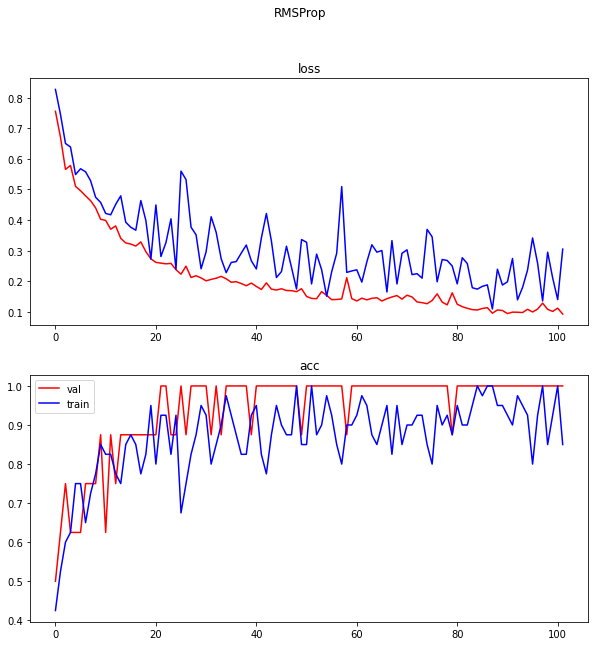

In [49]:
plt.figure(figsize=(10,10))
plt.title('dsadasdas')
plt.subplot(211)
plt.plot(val_loss,'-r',train_loss, 'b')
plt.title('loss')

plt.subplot(212)
plt.plot(val_acc,'-r',label='val')
plt.plot(train_acc, 'b',label='train')
plt.title('acc')
plt.legend()

plt.suptitle('RMSProp')

Text(0.5, 0.98, 'Adam')

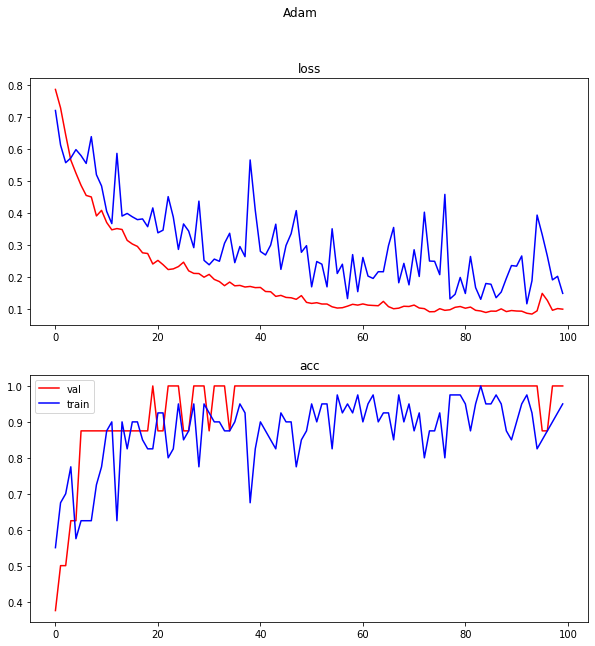

In [16]:
plt.figure(figsize=(10,10))
plt.title('dsadasdas')
plt.subplot(211)
plt.plot(val_loss,'-r',train_loss, 'b')
plt.title('loss')

plt.subplot(212)
plt.plot(val_acc,'-r',label='val')
plt.plot(train_acc, 'b',label='train')
plt.title('acc')
plt.legend()

plt.suptitle('Adam')

Text(0.5, 0.98, 'SGD')

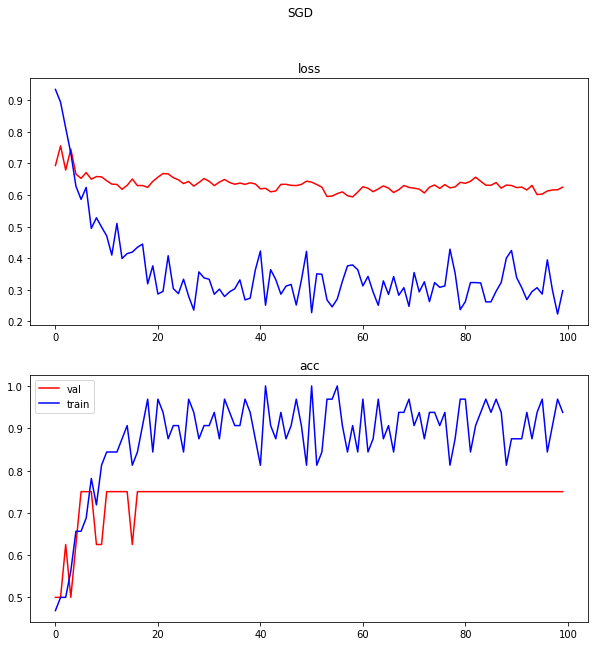

In [201]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(val_loss,'-r',train_loss, 'b')
plt.title('loss')

plt.subplot(212)
plt.plot(val_acc,'-r',label='val')
plt.plot(train_acc, 'b',label='train')
plt.title('acc')
plt.legend()

plt.suptitle('SGD')

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(val_loss,'-r',train_loss, 'b')
plt.ylim(0, 1.0)
plt.title('loss')

plt.subplot(212)
plt.plot(val_acc,'-r',label='val')
plt.plot(train_acc, 'b',label='train')
plt.title('acc')
plt.legend()

plt.suptitle('SGD_0.9')

In [29]:
test_dir = os.path.join(data_root, 'test')

In [31]:
test_dir

'/content/drive/My Drive/plates_data/working/test'

In [30]:
shutil.copytree(os.path.join(working_dir, 'test'), os.path.join(test_dir, 'unknown'))

KeyboardInterrupt: ignored

In [20]:
torchvision.datasets.ImageFolder()

TypeError: ignored

In [35]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [36]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 60/60 [00:39<00:00,  1.52it/s]


In [38]:
len(test_predictions)

473

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


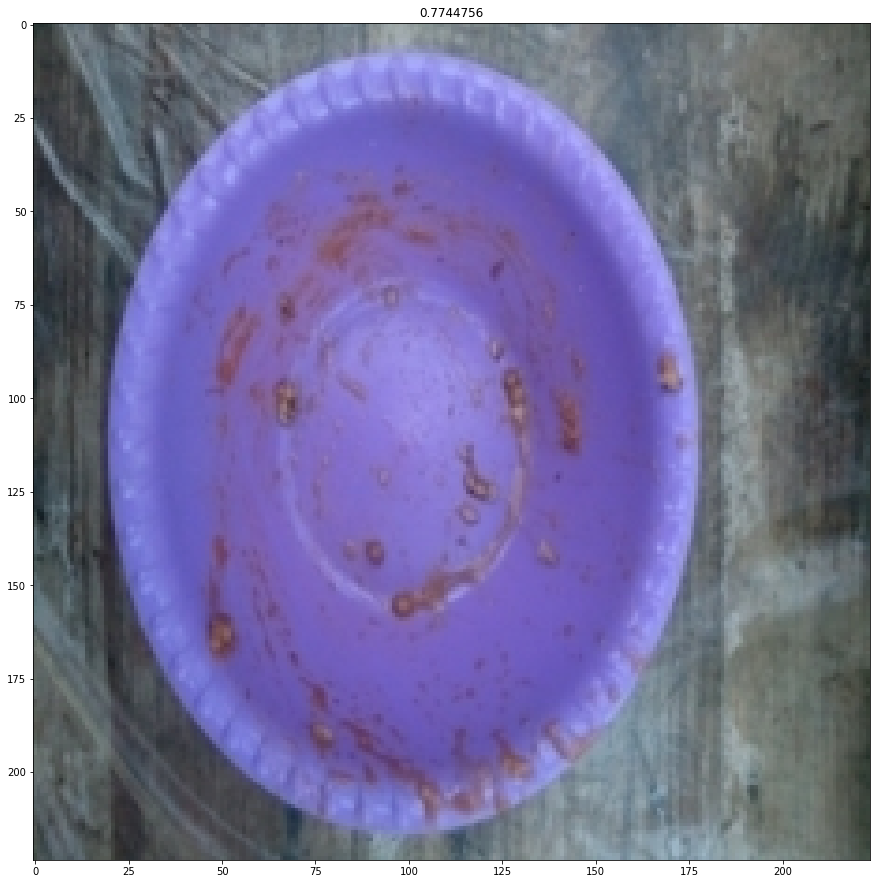

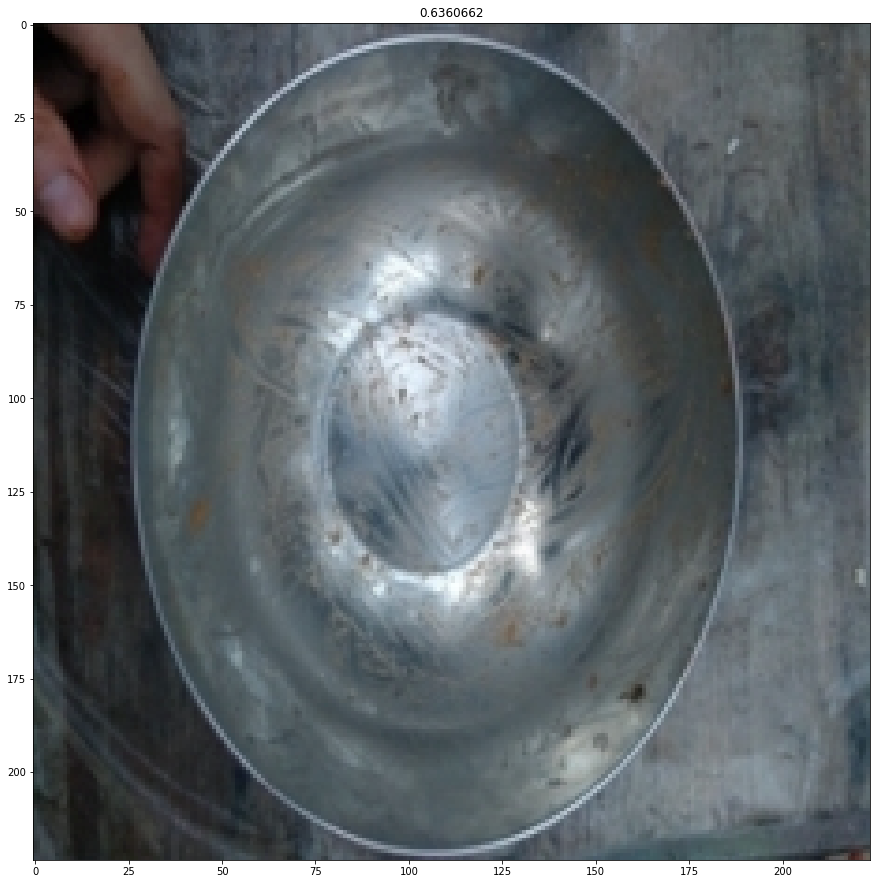

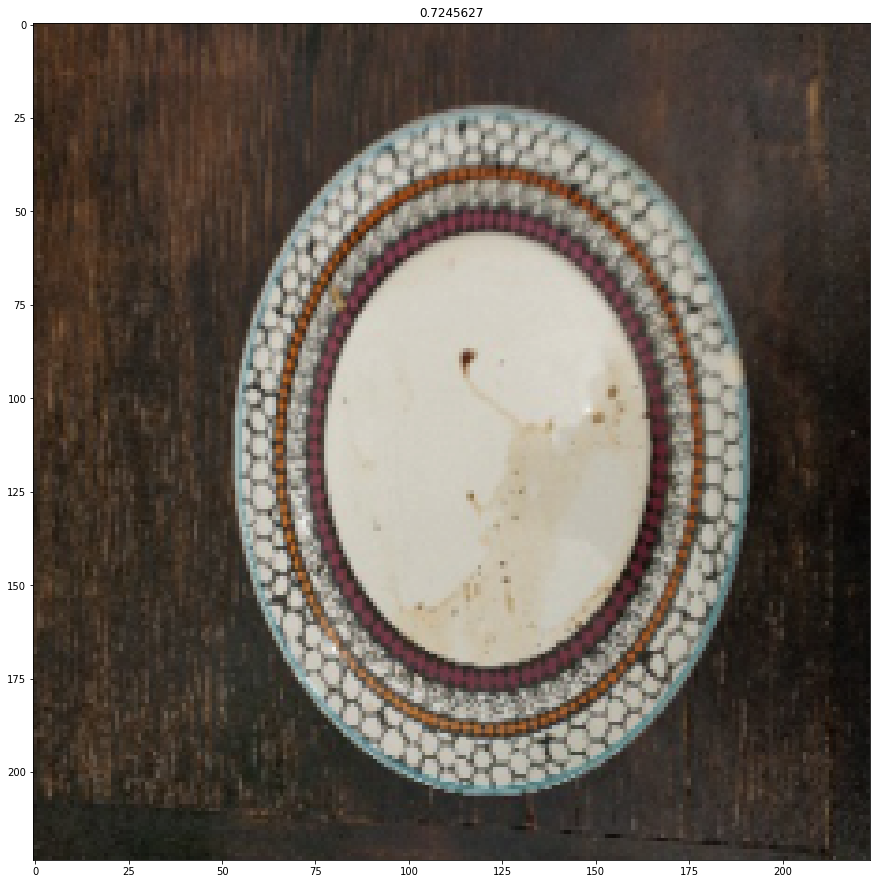

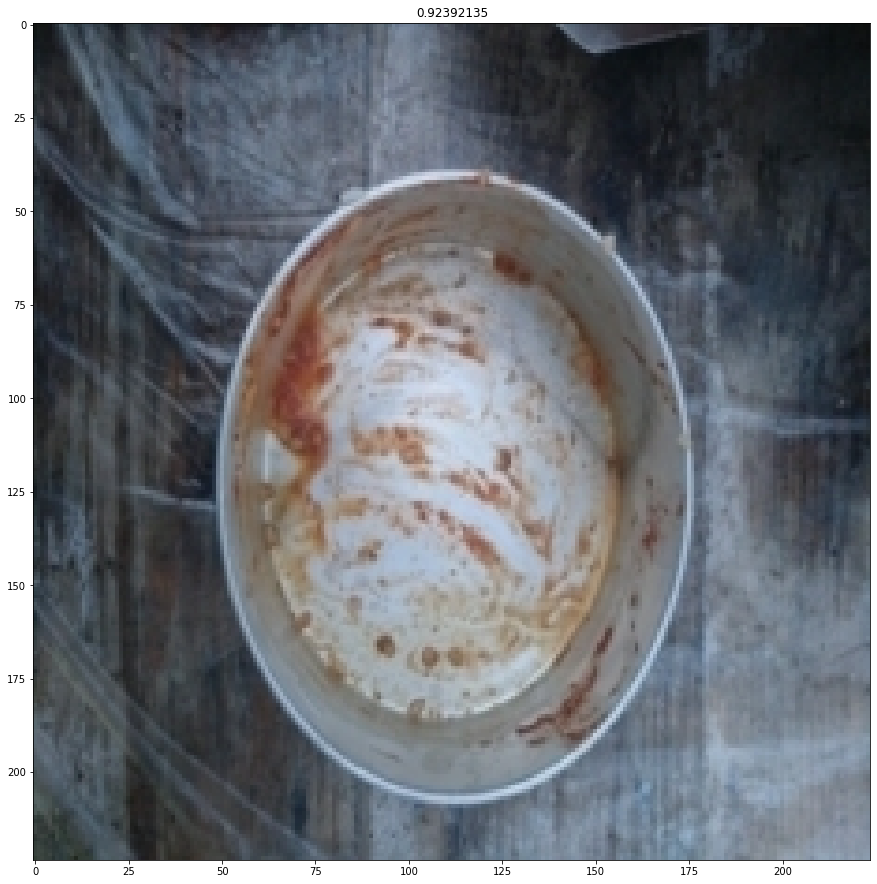

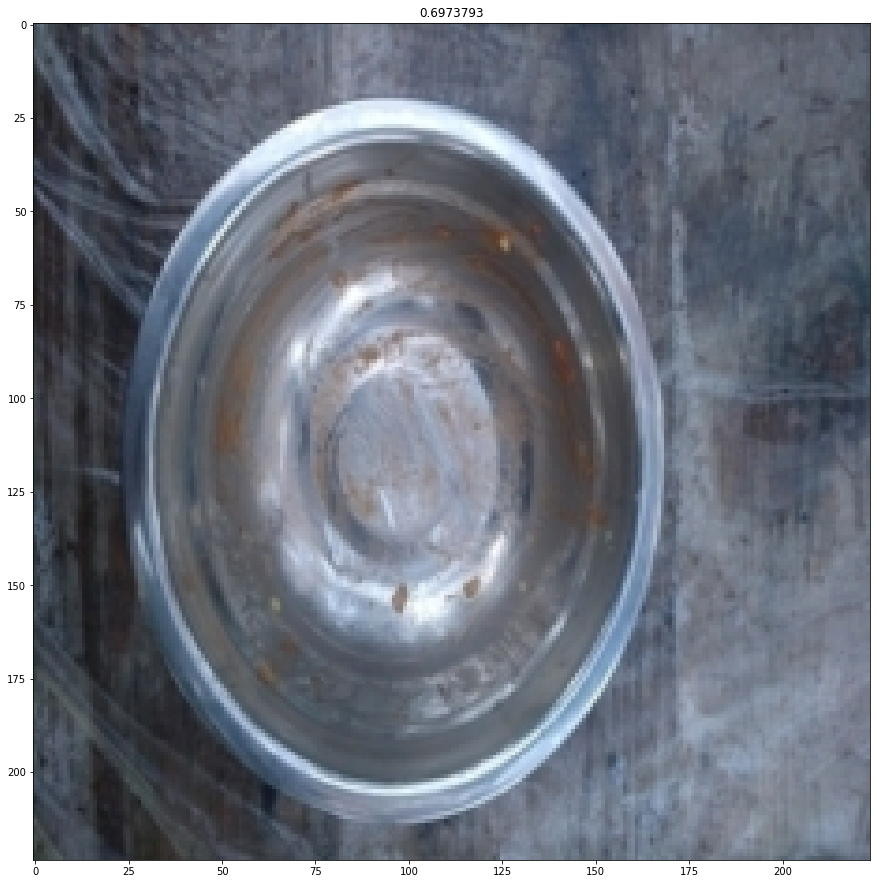

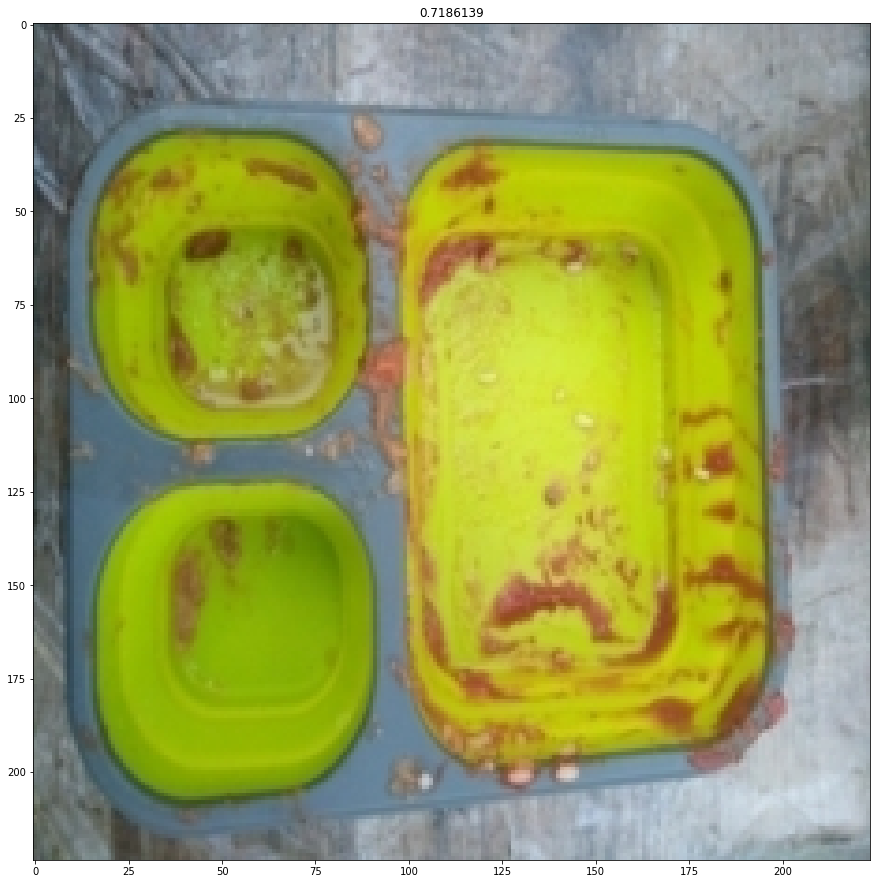

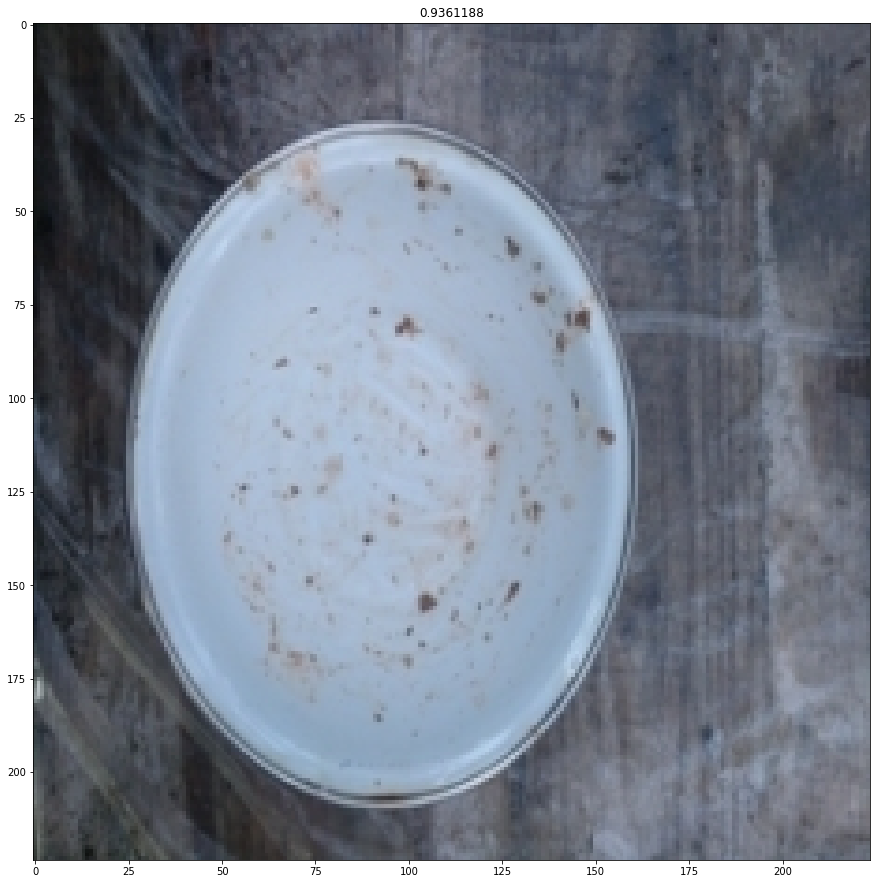

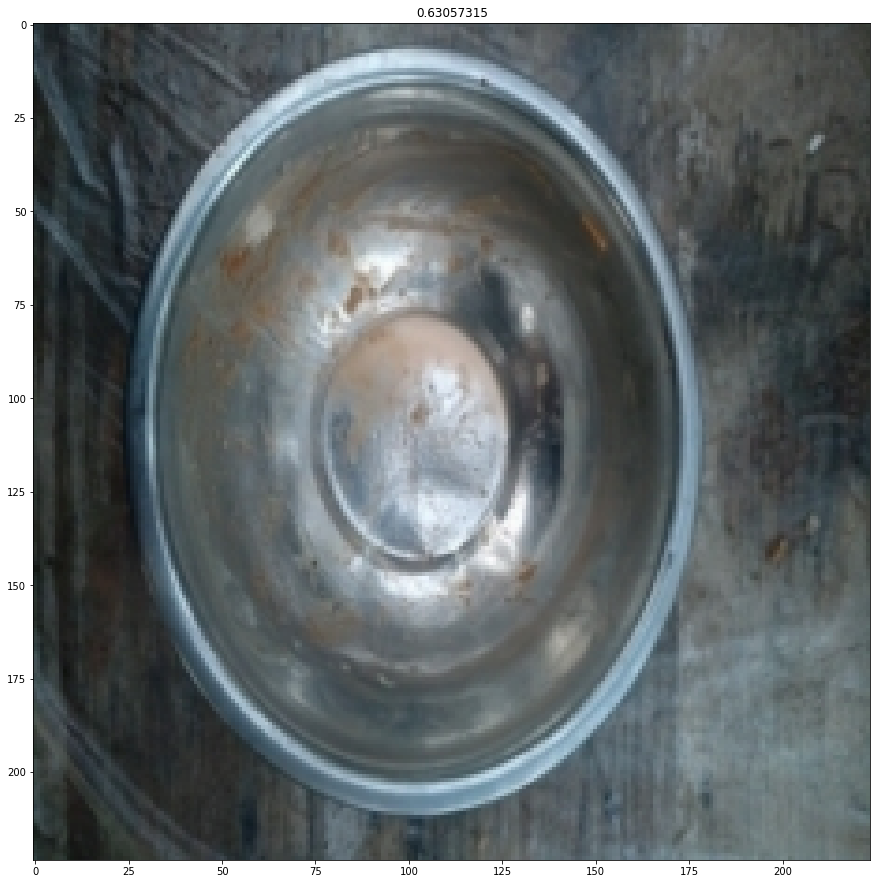

In [39]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [40]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [41]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

label
id                                                     
/content/drive/My Drive/plates_data/working/0000  dirty
/content/drive/My Drive/plates_data/working/0001  dirty
/content/drive/My Drive/plates_data/working/0002  dirty
/content/drive/My Drive/plates_data/working/0003  dirty
/content/drive/My Drive/plates_data/working/0004  dirty
/content/drive/My Drive/plates_data/working/0005  dirty

In [42]:
submission_df.to_csv('submission.csv')

In [45]:
print(os.listdir(os.curdir))

['.config', 'drive', 'submission.csv', 'test', 'sample_data']


In [47]:
!rm -rf train val test